In [1]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Dataset
from graph_based_ad import GraphBasedAnomalyDetection
from utils import Parameters, visualize_sequence
from data_loading import *
from shared.component_logger import component_logger as logger
import os

import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
params = Parameters()
params.seed = 0
params.batch = 256 # Batch size
params.epoch = 50 # number of epochs to train for
params.slide_win = 5 #size of the sliding window
params.dim = 64 # Embedding_dimension
params.slide_stride = 1 # Stride of sliding window
params.device = "cuda" if torch.cuda.is_available() else "cpu" # Device to run the model
params.out_layer_num = 1 # Number of output layers in GDN
params.out_layer_inter_dim = 128 # Dimension of output layers
params.decay = 0 # Decay of learning rate
params.topk = 15 # Number of topk neighbors
params.early_stop_win = 5 # Early stopping window
params.model_save_path = "checkpoints" #save path for checkpoints
params.data_save_path = "data"

In [3]:
torch.manual_seed(params.seed)
np.random.seed(params.seed)
random.seed(params.seed)

In [4]:
train_path = os.path.join(params.data_save_path, "swat_train_n.csv")
test_path = os.path.join(params.data_save_path, "swat_test_n.csv")

train, test, columns = real_data_loading(train_path, test_path)

2022-08-03 00:00:47.594018: INFO: graph_deviation_network: real_data_loading: Shape of train data: (496800, 51)
2022-08-03 00:00:47.600042: INFO: graph_deviation_network: real_data_loading: Shape of test data: (449919, 51)


In [5]:
class TimeDataset(Dataset):
    """
        TimeDataset is a class that inherits from Dataset and TS_graph_preprocessor.
        It is used to load the data for the TimeSeries dataset.

        Parameters
        ----------
        raw_data : List of rows from the dataframe. With labels in the last column of the rows.
        
        edge_index : edge index/ adjacency matrix of the graph
        
        mode: str
            mode of the dataset. Can be either "train" or "test"
        
        stride: int
            stride of the sliding window for forecasting
        
        window_len: int
            length of the sliding window for node features. 

        Returns
        -------
            Node Feature(X(t - slide_win - 1.....t-1) are the features), forecast(X(t)), label(attack label at X(t)), edge_index(Fully connected graph)
    """
    def __init__(self, raw_data, edge_index, mode, stride, window_len, label= False):
        super(TimeDataset, self).__init__()
        self.raw_data = raw_data # raw data
        self.edge_index = edge_index # edge index
        self.mode = mode # train or test
        self.slide_win = window_len # sliding window length
        self.slide_stride = stride # sliding window stride
        self.label = label # Flag for labelled train data
        if not self.label:
            x_data = raw_data 
            labels = None 
        else:
            x_data = raw_data[:-1] # X(t - slide_win - 1.....t-1) are the features, size of the features = sliding window length
            labels = raw_data[-1] # attack label at X(t)
        
        data = x_data 
        data = torch.tensor(data).double() # X(t - slide_win - 1.....t-1) are the features
        if not self.label:
            labels = None
        else:
            labels = torch.tensor(labels).double() # attack label at X(t)

        self.x, self.y, self.labels = self.preprocess_sliding(data, labels, label) # X(t - slide_win - 1.....t-1) are the features, X(t), attack label at X(t)
    

    def preprocess_sliding(self, data: torch.Tensor, labels: torch.Tensor, label: bool):
        """
        Given the data and labels, preprocess by sliding over the data and labels with a sliding window to return the node features, forecast, and labels.
        
        X(t - slide_win - 1.....t-1) are the features
        X(t) is the forecast
        attack label at (t) is the label
        
        """
        x_arr, y_arr = [], []
        labels_arr = []

        try:
            is_train = self.mode == 'train'
            node_num, total_time_len = data.shape
            rang = range(self.slide_win, total_time_len, self.slide_stride) if is_train else range(self.slide_win, total_time_len)
            # sliding window for node features and labels
            for i in rang:
                ft = data[:, i-self.slide_win:i] # X(t - slide_win - 1.....t-1) are the features
                tar = data[:, i] # X(t) is the target
                x_arr.append(ft) # append X(t - slide_win - 1.....t-1) are the features
                y_arr.append(tar) # append X(t)
                if label:
                    labels_arr.append(labels[i]) # append attack label at (t) or corresponding X(t)
                else:
                    labels_arr.append(None)
            x = torch.stack(x_arr).contiguous()
            y = torch.stack(y_arr).contiguous()
            if label:
                labels = torch.Tensor(labels_arr).contiguous()
        except Exception as error:
            logger.log("Failed to process data: {}".format(error))
            exit()
        
        return x, y, labels
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # return self.x[idx], self.y[idx], self.labels[idx] # X(1.....t-1), X(t), attack label at X(t)
        feature = self.x[idx].double()
        y = self.y[idx].double()
        edge_index = self.edge_index.long()
        if self.label:
            label = self.labels[idx].double()
        else:
            label = torch.Tensor([]).double()
        return feature, y, label, edge_index

In [6]:
if 'attack' in train.columns:
    train = train.drop(columns=['attack'])

fc_struc = get_fc_graph_struc(columns)

# fc_edge_index -> returns a fully connected edge index with no self connections
fc_edge_index = build_loc_net(fc_struc, list(train.columns), feature_map=columns)
fc_edge_index = torch.tensor(fc_edge_index, dtype = torch.long)

logger.log("Created Fully Connected Graph")

#train labels are set to 0
train_dataset_indata = construct_data(train, columns, label = True, labels=0)
test_dataset_indata =  construct_data(test, columns, label = True, labels=test.attack.tolist())


#generating features, labels in windows 
train_dataset = TimeDataset(train_dataset_indata, fc_edge_index, mode='train', stride = params.slide_stride, window_len = params.slide_win, label = True)
test_dataset = TimeDataset(test_dataset_indata, fc_edge_index, mode='test', stride = params.slide_stride, window_len = params.slide_win, label = True)

logger.log("Created Sequences")

2022-08-03 00:00:49.286312: INFO: graph_deviation_network: <cell line: 10>: Created Fully Connected Graph
2022-08-03 00:00:50.822136: INFO: graph_deviation_network: <cell line: 21>: Created Sequences


In [7]:
# Data loaders
train_dataloader, val_dataloader = get_tensor_loaders(train_dataset, params.batch, val_ratio = 0.1)
test_dataloader = DataLoader(test_dataset, batch_size= params.batch, shuffle=False, num_workers=0)

params.edge_index = fc_edge_index
params.node_num = len(columns)

In [8]:
gdn = GraphBasedAnomalyDetection(params)

2022-08-03 00:00:50.924001: INFO: graph_deviation_network: __init__: Trainable Parameters in Generator: 4,225


In [9]:
train_loss_list = gdn.train(train_dataloader, val_dataloader)

2022-08-03 00:01:00.464935: INFO: graph_deviation_network: train: Epoch: 1; mse_train: 0.0964; mse_valid: 0.0182
2022-08-03 00:01:07.657714: INFO: graph_deviation_network: train: Epoch: 2; mse_train: 0.0236; mse_valid: 0.0081
2022-08-03 00:01:14.766056: INFO: graph_deviation_network: train: Epoch: 3; mse_train: 0.0148; mse_valid: 0.0063
2022-08-03 00:01:21.699161: INFO: graph_deviation_network: train: Epoch: 4; mse_train: 0.0116; mse_valid: 0.0046
2022-08-03 00:01:28.737379: INFO: graph_deviation_network: train: Epoch: 5; mse_train: 0.0092; mse_valid: 0.0035
2022-08-03 00:01:35.682714: INFO: graph_deviation_network: train: Epoch: 6; mse_train: 0.0084; mse_valid: 0.0033
2022-08-03 00:01:42.654069: INFO: graph_deviation_network: train: Epoch: 7; mse_train: 0.0081; mse_valid: 0.0029
2022-08-03 00:01:49.721075: INFO: graph_deviation_network: train: Epoch: 8; mse_train: 0.0076; mse_valid: 0.0028
2022-08-03 00:01:56.710596: INFO: graph_deviation_network: train: Epoch: 9; mse_train: 0.0071; m

In [10]:
test.to_csv(os.path.join(params.data_save_path, "swat_downsample_test.csv")) 
gdn.eval_model(test_dataloader, val_dataloader)

2022-08-03 00:04:19.684502: INFO: graph_deviation_network: eval_model: ------------Evaluation Report------------
2022-08-03 00:04:19.689489: INFO: graph_deviation_network: eval_model: Precision: 0.9969951923076923
2022-08-03 00:04:19.695473: INFO: graph_deviation_network: eval_model: Recall: 0.6044816906540353
2022-08-03 00:04:19.701463: INFO: graph_deviation_network: eval_model: F1 score: 0.7526369513439946


In [11]:
anomaly_indices = gdn.predict(test_dataloader)
logger.log(anomaly_indices[:100])

2022-08-03 00:04:33.815388: INFO: graph_deviation_network: predict: Amount of outliers detetced: 3328
2022-08-03 00:04:33.825517: INFO: graph_deviation_network: <cell line: 2>: [  308  1555  1556  1557  1558  1559  1560  1561  1562  1563  1564  1565
2022-08-03 00:04:33.825517: INFO: graph_deviation_network: <cell line: 2>:   1566  1567  1568  1569  1570  1571  1572  1573  1574  1575  1576  1577
2022-08-03 00:04:33.825517: INFO: graph_deviation_network: <cell line: 2>:   1578  1579  1580  1581  1582  1583  1584  1585  1586  1587  1588  1589
2022-08-03 00:04:33.825517: INFO: graph_deviation_network: <cell line: 2>:   1590  1591  1592  1593  1594  1595  1596  1597  1598  1599  1600  1601
2022-08-03 00:04:33.825517: INFO: graph_deviation_network: <cell line: 2>:   1602  1603  1604  1605  1606  1607 13293 13294 13295 13296 13297 13298
2022-08-03 00:04:33.825517: INFO: graph_deviation_network: <cell line: 2>:  13299 13300 13301 13302 13303 13304 13305 13306 13307 13308 13309 13310
2022-08-03

2022-08-03 00:04:33.851394: INFO: graph_deviation_network: visualize_sequence: Cols is not set, defaulted to df.columns
2022-08-03 00:04:36.927094: INFO: graph_deviation_network: visualize_sequence: Failed to visualize: [Errno 2] No such file or directory: 'checkpoints/checkpoints/plots/GDN.png'


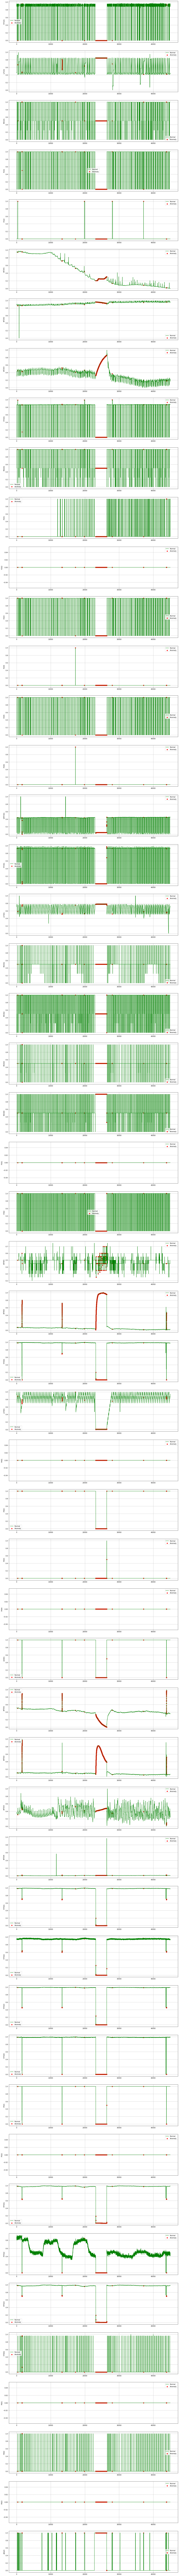

In [12]:
visualize_sequence(test, anomaly_index= anomaly_indices, plot_file_name='checkpoints/plots/GDN.png')